In [3]:
#hide
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    %pip install -Uqq fastai fastbook
    
import fastbook
fastbook.setup_book()

In [4]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# From Model to Production

# Setting Azure Seach API Key


In [5]:
if iskaggle:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    key = user_secrets.get_secret("AZURE_SEARCH_KEY")
else:    
    key = os.environ.get('AZURE_SEARCH_KEY', '')



Using `search_images_bing` function to retrieve a random image for the keyword.

In [7]:
results = search_images_bing(key, 'rose')
ims = results.attrgot('contentUrl')
len(ims)

150

The first image of the downloaded result for rose. 

In [8]:
print(ims[0])

https://d3d0lqu00lnqvz.cloudfront.net/media/media/897b2e5d-6d4c-40fa-bbe8-6829455747e2.jpg


Save the first image to a file

In [9]:
dest = 'images/rose.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

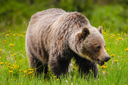

In [10]:
im = Image.open(dest)
im.to_thumb(128,128)

In [11]:
flower_types = 'tulip','daisy','rose'
path = Path('flower')

In [12]:
if not path.exists():
    path.mkdir()
    for o in flower_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} flower')
        download_images(dest, urls=results.attrgot('contentUrl'))

Our folder has image files, as we'd expect:

In [13]:
fns = get_image_files(path)
fns

(#424) [Path('bears/teddy/cd6fe7b4-7849-44e4-825c-64723e0c6ee8.png'),Path('bears/teddy/daa352ef-0d61-43c1-9de8-82be043a8318.jpg'),Path('bears/teddy/6cc610b7-1c83-4bd9-89d7-8fe3eab3f0bc.jpg'),Path('bears/teddy/8d4e7824-9ba0-44e7-bd1b-ad889f76a78b.jpg'),Path('bears/teddy/81db1a9a-7a7a-403f-9f52-258ed97952ee.jpg'),Path('bears/teddy/847cb609-84f3-4ad0-8d06-c6d37321017a.jpg'),Path('bears/teddy/ccb606cf-4b68-417d-870a-418fd77a6da1.jpg'),Path('bears/teddy/157049d4-305d-44c6-8162-284d2c7c96cb.jpg'),Path('bears/teddy/0c4281ad-5465-4eb5-ad30-29ece1fd397d.jpg'),Path('bears/teddy/ff5cb1af-e761-4d92-944a-19dbdc4b21ae.jpg')...]

Let's remove corrupted files in the downloads. First, there are a few that are corrupt. Let's check:

In [14]:
failed = verify_images(fns)
failed

(#15) [Path('bears/teddy/81db1a9a-7a7a-403f-9f52-258ed97952ee.jpg'),Path('bears/teddy/ec26838f-481c-4f2f-91a1-9f7df107ca72.jpg'),Path('bears/teddy/bd0d62d2-adf0-4f3b-b63a-ad013476b7c2.jpg'),Path('bears/teddy/ddd4f4a5-291d-490c-abeb-18cd34f0990d.jpg'),Path('bears/teddy/0e780c78-2a1d-4739-8281-298d81f66133.jpg'),Path('bears/teddy/a3476fd3-f71c-4192-b056-5fbd50cd25f3.jpg'),Path('bears/teddy/21b54cbe-931b-4d2e-a354-3142194f02ee.jpg'),Path('bears/teddy/f2c9afba-0ca7-45bc-ba0b-f0b3f2fdbe73.jpg'),Path('bears/grizzly/d448c665-9b8b-4cc9-bfd8-294940caab3c.jpg'),Path('bears/black/3ebb5098-2932-4b98-81b3-4a90fadf9dd8.jpg')...]

To remove all the failed images, you can use `unlink` on each of them. Note that, like most fastai functions that return a collection, `verify_images` returns an object of type `L`, which includes the `map` method. This calls the passed function on each element of the collection:

In [15]:
failed.map(Path.unlink);

Now it's time to build a `DataLoaders` that Learner object will use.

## From Data to DataLoaders

In [16]:
roses = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

dls = roses.dataloaders(path)

This build block for DataBlock

```python
blocks=(ImageBlock, CategoryBlock)
```

This indicates that images are our target and categories as a dependent variable.
The get_image_files function is supplied as a parameter, which returns a list of all of the images in the path.

```python
get_items=get_image_files
```
We are using random splitter provided by fastai. If same seed is used to split the data set then next split will end up same way. The split between train and validation in this case is 8:2.


```python
splitter=RandomSplitter(valid_pct=0.2, seed=42)
```

```python
get_y=parent_label
```

`parent_label` a function to return the name of the folder, which will serve as labels. Training requires images to have same size thus resize them to 128.

```python
item_tfms=Resize(128)
```

Need to specify the location of input files

```python
dls = roses.dataloaders(path)
```

A `DataLoaders` includes validation and training `DataLoader`s. `DataLoader` is a class that provides batches of a few items at a time to the GPU. We'll be learning a lot more about this class in the next chapter. When you loop through a `DataLoader` fastai will give you 64 (by default) items at a time, all stacked up into a single tensor. We can take a look at a few of those items by calling the `show_batch` method on a `DataLoader`:

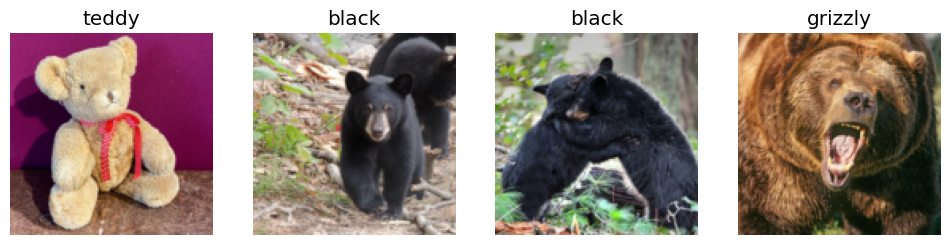

In [18]:
dls.valid.show_batch(max_n=4, nrows=1)

By default `Resize` *crops* the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them:

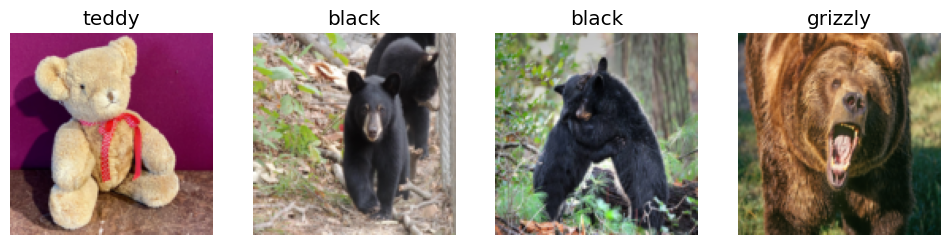

In [20]:
bears = roses.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = roses.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

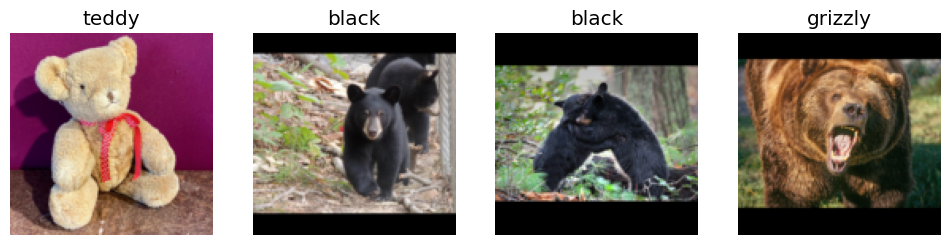

In [19]:
roses = roses.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = roses.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Let's use `RandomResizedCrop` for variations as part of augmentation.

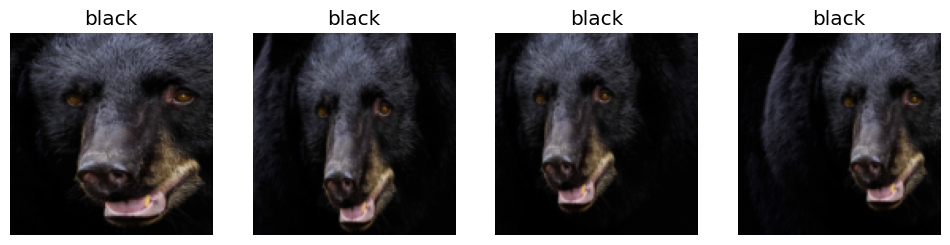

In [21]:
roses = roses.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = roses.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

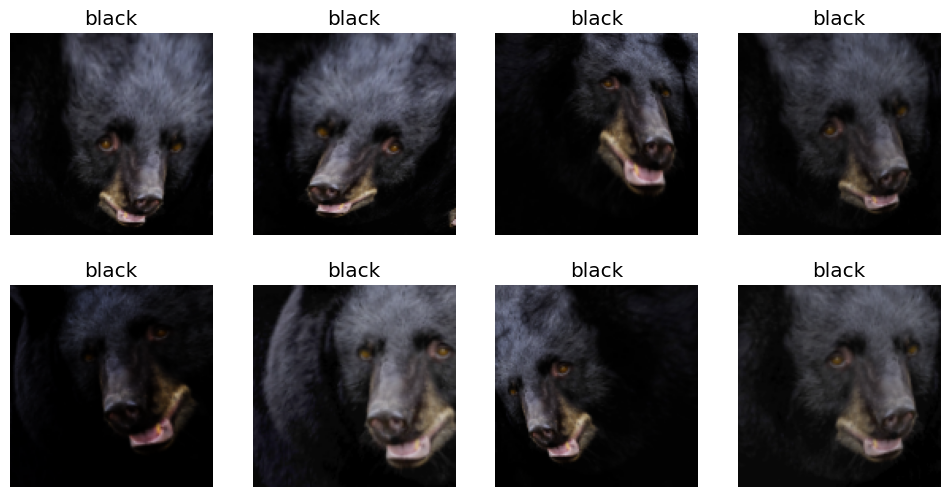

In [22]:
roses = roses.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = roses.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Now that we have assembled our data in a format fit for model training, let's actually train an image classifier using it.

## Training Your Model, and Using It to Clean Your Data

Time to use the same lines of code as in <<chapter_intro>> to train our bear classifier.

We don't have a lot of data for our problem (150 pictures of each sort of bear at most), so to train our model, we'll use `RandomResizedCrop` with an image size of 224 px, which is fairly standard for image classification, and default `aug_transforms`:

In [23]:
roses = roses.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = roses.dataloaders(path)

We can now create our `Learner` and fine-tune it in the usual way:

In [25]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.239671,0.077440,0.024691,00:47


epoch,train_loss,valid_loss,error_rate,time
0,0.150295,0.024758,0.012346,01:08
1,0.123557,0.016582,0.012346,01:07
2,0.089978,0.013118,0.012346,01:06
3,0.080011,0.007482,0.000000,01:06


Let's check if the classification performed well. We can create a *confusion matrix*:

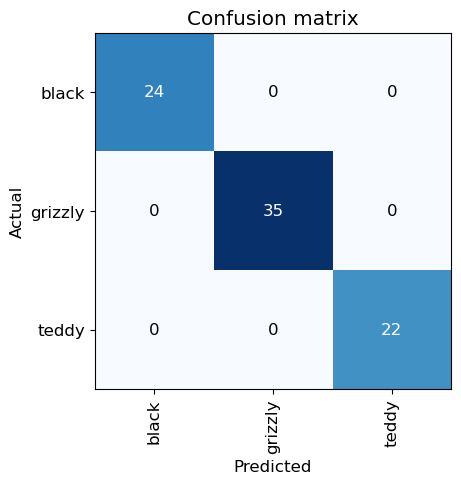

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The rows represent all the black, grizzly, and teddy bears in our dataset, respectively. The columns represent the images which the model predicted as black, grizzly, and teddy bears, respectively. Therefore, the diagonal of the matrix shows the images which were classified correctly, and the off-diagonal cells represent those which were classified incorrectly. This is one of the many ways that fastai allows you to view the results of your model. It is (of course!) calculated using the validation set. With the color-coding, the goal is to have white everywhere except the diagonal, where we want dark blue. Our bear classifier isn't making many mistakes!

It's helpful to see where exactly our errors are occurring, to see whether they're due to a dataset problem (e.g., images that aren't bears at all, or are labeled incorrectly, etc.), or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.). To do this, we can sort our images by their *loss*.

The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer. In a couple of chapters we'll learn in depth how loss is calculated and used in the training process. For now, `plot_top_losses` shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The *probability* here is the confidence level, from zero to one, that the model has assigned to its prediction:

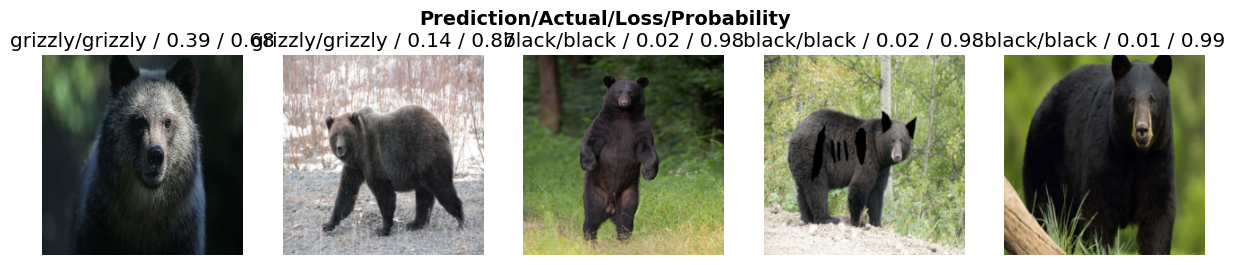

In [27]:
interp.plot_top_losses(5, nrows=1)

This output shows that the image with the highest loss is one that has been predicted as "grizzly" with high confidence. However, it's labeled (based on our Bing image search) as "black." We're not bear experts, but it sure looks to us like this label is incorrect! We should probably change its label to "grizzly."

The intuitive approach to doing data cleaning is to do it *before* you train a model. But as you've seen in this case, a model can actually help you find data issues more quickly and easily. So, we normally prefer to train a quick and simple model first, and then use it to help us with data cleaning.

fastai includes a handy GUI for data cleaning called `ImageClassifierCleaner` that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

In [ ]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

<img alt="Cleaner widget" width="700" src="images/att_00007.png">

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

We can see that amongst our "black bears" is an image that contains two bears: one grizzly, one black. So, we should choose `<Delete>` in the menu under this image. `ImageClassifierCleaner` doesn't actually do the deleting or changing of labels for you; it just returns the indices of items to change. So, for instance, to delete (`unlink`) all images selected for deletion, we would run:

```python
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
```

To move images for which we've selected a different category, we would run:

```python
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
```

> s: Cleaning the data and getting it ready for your model are two of the biggest challenges for data scientists; they say it takes 90% of their time. The fastai library aims to provide tools that make it as easy as possible.

We'll be seeing more examples of model-driven data cleaning throughout this book. Once we've cleaned up our data, we can retrain our model. Try it yourself, and see if your accuracy improves!

> note: No Need for Big Data: After cleaning the dataset using these steps, we generally are seeing 100% accuracy on this task. We even see that result when we download a lot fewer images than the 150 per class we're using here. As you can see, the common complaint that _you need massive amounts of data to do deep learning_ can be a very long way from the truth!

Now that we have trained our model, let's see how we can deploy it to be used in practice.

Now, it's time to package it for production run.

When you call `export`, fastai will save a file called "export.pkl":

In [ ]:
learn.export()

Let's check that the file exists, by using the `ls` method that fastai adds to Python's `Path` class:

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

The predicting process using the model package is called inference.

In [ ]:
learn_inf = load_learner(path/'export.pkl')

When we're doing inference, we're generally just getting predictions for one image at a time. To do this, pass a filename to `predict`:

In [ ]:
learn_inf.predict('images/rose.jpg')

('grizzly', tensor(1), tensor([9.0767e-06, 9.9999e-01, 1.5748e-07]))

This has returned three things: the predicted category in the same format you originally provided (in this case that's a string), the index of the predicted category, and the probabilities of each category. The last two are based on the order of categories in the *vocab* of the `DataLoaders`; that is, the stored list of all possible categories. At inference time, you can access the `DataLoaders` as an attribute of the `Learner`:

In [ ]:
learn_inf.dls.vocab

(#3) ['black','grizzly','teddy']

We can see here that if we index into the vocab with the integer returned by `predict` then we get back "grizzly," as expected. Also, note that if we index into the list of probabilities, we see a nearly 1.00 probability that this is a grizzly.

We know how to make predictions from our saved model, so we have everything we need to start building our app. We can do it directly in a Jupyter notebook.